In [1]:
# general
import _pickle as cPickle
import re
import multiprocessing
from collections import defaultdict
from collections import namedtuple
import datetime
import os
import pandas as pd
import numpy as np

# NLP
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.models.word2vec import Word2Vec
from gensim.models import Phrases
from fuzzywuzzy import fuzz

# clfs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb

# NN
from keras.models import Model, load_model
from keras.layers import Input, Dense, merge
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]='0'

/home/admin0/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/home/admin0/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/train_min.csv')
df_test = pd.read_csv('data/test_min.csv')

In [46]:
tdf = xdf.copy()
tdf_test = xdf_test.copy()
for f in df.columns:
    if f not in xdf.columns and 'id' not in f:
        tdf[f] = df[f]
        tdf_test[f] = df_test[f]
tdf_test['test_id'] = df_test['test_id']

# When Questions Duplicate?

Let $q_1, q_2$ be a pair of questions to compare.<br>
Ideally, we'd like to find a similarity metric, st $\text{sim}(q_1,q_2)$ is high => duplicate, and low otherwise.<br>
However, after looking at the data, several issues
 1. minor difference(mispelling/grammatical) => character-level similarity
  - duplicate<br>
    "Should people over 98 not be allowed to vote?"<br>
    "Should people over 96 not be allowed to vote?"
  - non-duplicate<br>
    "What are some solved problems in mathematics?"<br>
    "What are some unsolved problems in mathematics?"
  - percentage of duplicate vs non-duplicate?
 2. differ in only synonyms => word-level similarity
  - always duplicate<br>
    "How can you determine the boiling point of a substance?"<br>
    "How do you calculate the boiling point of a substance?"
 3. differ in length, explained in more detail => common-word match
  - mostly duplicate<br>
    "Can a person lose weight without going to the gym?"<br>
    "Can I lose weight and grow muscle without going to the gym or without using weights?"
 4. differ in word order => sort before common-word match
  - mostly duplicate<br>
    "Is it possible that Trump entered the Presidential campaign to ensure that Hillary Clinton wins?"<br>
    "Is Hillary Clinton secretly paying Donald Trump to throw the election?"
 5. differ in question coverage $q_1\in q_2$
  - mostly non-duplicate<br>
    "What is the step by step guide to invest in share market?"<br>
    "What is the step by step guide to invest in share market in india?"
 6. (hard) duplicate with antonyms => compare antonym with position
  - "Is bungee jumping dangerous?"<br>
    "How safe is bungee jumping?"
  - "Why shouldn't I vote for Donald Trump?"<br>
    "Why should I not vote for Trump?"

## Are Classes Balanced?

duplicate vs non-duplicate = 1:2 => upscaling dupicate samples helps(? no)

In [ ]:
is_dup = df['is_duplicate'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.savefig('fig/label-dist.png')
is_dup/np.sum(is_dup)

## Are Questions Compared Equally?
 motivate magic features

In [ ]:
print('Total number of question pairs for training: {}'.format(len(df)))
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(15, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.savefig('fig/question-freq.png')

## Fair Splitting of Train/Testing Data?
most frequent words are roughly the same.

In [ ]:
def count(qs, ngram=1):
    wc = {}
    for i in range(qs.shape[0]):
        ws = list(map(lambda w:w.strip(), re.split('[^\w]', qs[i])))
        ws = [x for x in ws if x != '']
        for i in range(len(ws)):
            if i+ngram > len(ws):
                break
            cur = ' '.join(ws[i:i+ngram])
            wc[cur] = 1 if cur not in wc.keys() else wc[cur]+1
    return wc
def plot(wrank, topk, out=''):
    fig = plt.figure(figsize=(15,5))
    plt.plot(range(topk), [wrank[i][0] for i in range(topk)])
    plt.xticks(range(topk), [wrank[i][1] for i in range(topk)])
    if len(out)>0:
        plt.savefig(out)
    else:
        plt.show()

Q = df['question1'].append(df['question2']).fillna('')
n1 = count(Q.values, ngram=1)
n2 = count(Q.values, ngram=2)
print('#distinct vocabularies: {}'.format(len(n1)))
rn1 = list(reversed(sorted([(v,k) for (k,v) in n1.items()])))
print('#distinct vocabularies: {}'.format(len(n2)))
rn2 = list(reversed(sorted([(v,k) for (k,v) in n2.items()])))
plot(rn1, 20, out='fig/train-topugram.png')
plot(rn2, 20, out='fig/train-topbgram.png')
Q_test = df_test['question1'].append(df_test['question2']).fillna('')
n1_test = count(Q_test.values, ngram=1)
n2_test = count(Q_test.values, ngram=2)
print('#distinct vocabularies: {}'.format(len(n1_test)))
rn1_test = list(reversed(sorted([(v,k) for (k,v) in n1_test.items()])))
print('#distinct vocabularies: {}'.format(len(n2_test)))
rn2_test = list(reversed(sorted([(v,k) for (k,v) in n2_test.items()])))
plot(rn1_test, 20, out='fig/test-topugram.png')
plot(rn2_test, 20, out='fig/test-topbgram.png')

## Clean Text

In [ ]:
stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']
def clean(text):
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0k ", "0000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    text = ' '.join([x for x in text.split(' ') if x not in stop_words])
    return text

df['q1_clean'] = df['question1'].apply(lambda x:clean(str(x)))
df['q2_clean'] = df['question2'].apply(lambda x:clean(str(x)))
df_test['q1_clean'] = df_test['question1'].apply(lambda x:clean(str(x)))
df_test['q2_clean'] = df_test['question2'].apply(lambda x:clean(str(x)))
df.to_csv('data/train_clean.csv')
df_test.to_csv('data/test_clean.csv')

## WMD of questions
A good metric that meets above similarity requirements. However, calculating WMD is slow:
 * 15 min / 100,000 pairs on a single-thread => total requires 15*55/60=13.75hr<br>
 solution: parallel computing, start 64 threads concurrently

If we can find a good preprocessing function $\phi(q)$ to eliminate stopwords(phrases) and explaining words, we only have to deal with overlapping case:
 1. [ideal] $\text{sim}(\phi(q_1),\phi(q_2))$ is low => non-duplicate
 2. [ideal] $\text{sim}(\phi(q_1), \phi(q_2))$ is high => duplicate
 3. [issue] $\text{sim}(\phi(q_1),\phi(q_2))$ is high but $q_1\in q_2$ => non-duplicate!

cases (2) and (3) are hard to separate. However, if we let $q=q_1\cup q_2-q_1\cap q_2$, then
 1. $\text{sim}(q,q_1)>\text{sim}(q,q_2)\approx\text{sim}(q_1,q_2)$ => non-duplicate
 2. $\text{sim}(q,q_1)\approx\text{sim}(q,q_2)>\text{sim}(q_1,q_2)$ => non-duplicate

duplicate only when similarity between the 3 are all high!

In [ ]:
Q = df['question1'].append(df['question2'])
Q_test = df_test['question1'].append(df_test['question2'])
Q_all = Q.append(Q_test)
Q_sample = Q_all.sample(n=500000).values
bigram_transformer = Phrases(Q_sample)
model = Word2Vec(bigram_transformer[Q_sample], size=100, min_count=5, workers=10)
model.save('ckpt/bi.model')

def compute_wmd(ids, debug=False):
    D12, D1, D2 = [], [], []
    for i in ids:
        if i>cur_df.shape[0]-1:
            break
        x = cur_df.iloc[i]
        w1 = re.split('[^\w]', x['question1'])
        q = ' '.join(w1+[w2 for w2 in re.split('[^\w]', x['question2']) if w2 not in w1])
        d12 = model.wmdistance(x['question1'], x['question2'])
        d1 = model.wmdistance(q, x['question1'])
        d2 = model.wmdistance(q, x['question2'])
        if debug:
            print('Q1:{}\nQ2:{}\nduplicate={}\n{}'.format(x['question1'], x['question2'], x['is_duplicate'], q))
            print('WMD(q1,q2): {}'.format(d12))
            print('WMD(q, q1): {}'.format(d1))
            print('WMD(q, q2): {}'.format(d2))
            print('------------------------------------------')
        D12.append(d12)
        D1.append(d1)
        D2.append(d2)
    return [ids, D12, D1, D2]


cur_df = df
pn = 64
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_wmd, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()

RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][1],results[i][2],results[i][3]]
D12, D1, D2 = [], [], []
for i in range(pn):
    D12.extend(RST[i][0])
    D1.extend(RST[i][1])
    D2.extend(RST[i][2])

df['wmd12'] = D12
df['wmd1'] = D1
df['wmd2'] = D2
df.to_csv('data/train_wmd.csv')

cur_df = df_test
pn = 64
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_wmd, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()

RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][1],results[i][2],results[i][3]]
D12, D1, D2 = [], [], []
for i in range(pn):
    D12.extend(RST[i][0])
    D1.extend(RST[i][1])
    D2.extend(RST[i][2])

df_test['wmd12'] = D12
df_test['wmd1'] = D1
df_test['wmd2'] = D2
df_test.to_csv('data/test_wmd.csv')

df[['id','wmd12','wmd1','wmd2','is_duplicate']].corr()

In [ ]:
Q = df['q1_clean'].append(df['q2_clean'])
Q_test = df_test['q1_clean'].append(df_test['q2_clean'])
Q_all = Q.append(Q_test)
Q_sample = Q_all.sample(n=500000).values
bigram_transformer = Phrases(Q_sample)
model = Word2Vec(bigram_transformer[Q_sample], size=100, min_count=5, workers=10)
model.save('ckpt/bi-clean.model')
model = Word2Vec.load('ckpt/bi-clean.model')
def compute_wmd_clean(ids, debug=False):
    D12, D1, D2 = [], [], []
    for i in ids:
        if i>cur_df.shape[0]-1:
            break
        x = cur_df.iloc[i]
        w1 = re.split('[^\w]', x['q1_clean'])
        q = ' '.join(w1+[w2 for w2 in re.split('[^\w]', x['q2_clean']) if w2 not in w1])
        d12 = model.wmdistance(x['q1_clean'], x['q2_clean'])
        d1 = model.wmdistance(q, x['q1_clean'])
        d2 = model.wmdistance(q, x['q2_clean'])
        if debug:
            print('clean-Q1:{}\nclean-Q2:{}\nduplicate={}\n{}'.format(x['q1_clean'], x['q2_clean'], x['is_duplicate'], q))
            print('clean-WMD(q1,q2): {}'.format(d12))
            print('clean-WMD(q, q1): {}'.format(d1))
            print('clean-WMD(q, q2): {}'.format(d2))
            print('------------------------------------------')
        D12.append(d12)
        D1.append(d1)
        D2.append(d2)
    return [ids, D12, D1, D2]

cur_df = df
pn = 64
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_wmd_clean, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()

RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][1],results[i][2],results[i][3]]
D12, D1, D2 = [], [], []
for i in range(pn):
    D12.extend(RST[i][0])
    D1.extend(RST[i][1])
    D2.extend(RST[i][2])

df['wmd12_clean'] = D12
df['wmd1_clean'] = D1
df['wmd2_clean'] = D2
df.to_csv('data/train_wmd_clean.csv')
cur_df = df_test
pn = 64
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_wmd_clean, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()

RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][1],results[i][2],results[i][3]]
D12, D1, D2 = [], [], []
for i in range(pn):
    D12.extend(RST[i][0])
    D1.extend(RST[i][1])
    D2.extend(RST[i][2])

df_test['wmd12_clean'] = D12
df_test['wmd1_clean'] = D1
df_test['wmd2_clean'] = D2
df_test.to_csv('data/test_wmd_clean.csv')

df[['id','wmd12_clean','wmd1_clean','wmd2_clean','is_duplicate']].corr()

## Magic: Pair Combination Matters?
If the compared question pairs are selected by unknown algorithm inside Quora system, then
 * a question being compared more times
 * questions being compared by more similar questions

has higher chances to be duplicate

In [ ]:
def aug_magic1(df, df_test):
    df1 = df[['question1']].copy()
    df2 = df[['question2']].copy()
    df1_test = df_test[['question1']].copy()
    df2_test = df_test[['question2']].copy()
    df2.rename(columns = {'question2':'question1'},inplace=True)
    df2_test.rename(columns = {'question2':'question1'},inplace=True)
    train_questions = df1.append(df2)
    train_questions = train_questions.append(df1_test)
    train_questions = train_questions.append(df2_test)
    train_questions.drop_duplicates(subset = ['question1'],inplace=True)
    train_questions.reset_index(inplace=True,drop=True)
    questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
    train_cp = df.copy()
    test_cp = df_test.copy()
    train_cp.drop(['qid1','qid2'],axis=1,inplace=True)
    test_cp['is_duplicate'] = -1
    test_cp.rename(columns={'test_id':'id'},inplace=True)
    comb = pd.concat([train_cp,test_cp])
    comb['q1_hash'] = comb['question1'].map(questions_dict)
    comb['q2_hash'] = comb['question2'].map(questions_dict)
    q1_vc = comb['q1_hash'].value_counts().to_dict()
    q2_vc = comb['q2_hash'].value_counts().to_dict()
    def try_apply_dict(x,dict_to_apply):
        try:
            return dict_to_apply[x]
        except KeyError:
            return 0
    comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
    comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
    train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
    test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]
    print(train_comb.corr())
    for f in ['q1_hash', 'q2_hash', 'q1_freq', 'q2_freq']:
        df[f] = train_comb[f]
        df_test[f] = test_comb[f]
    return df, df_test

df_magic, df_test_magic = aug_magic1(df, df_test)
df_magic.to_csv('data/train_wmd_magic.csv')
df_test_magic.to_csv('data/test_wmd_magic.csv')
"""corr
                    id   q1_hash   q2_hash   q1_freq   q2_freq  is_duplicate
id            1.000000  0.692730  0.286969 -0.001608 -0.000777     -0.008784
q1_hash       0.692730  1.000000  0.492993 -0.341777 -0.202545     -0.206498
q2_hash       0.286969  0.492993  1.000000 -0.392605 -0.466434     -0.349626
q1_freq      -0.001608 -0.341777 -0.392605  1.000000  0.494315      0.296621
q2_freq      -0.000777 -0.202545 -0.466434  0.494315  1.000000      0.198609
is_duplicate -0.008784 -0.206498 -0.349626  0.296621  0.198609      1.000000
"""

In [ ]:
def aug_magic2(df, df_test):
    ques = pd.concat([df[['question1', 'question2']], df_test[['question1', 'question2']]], axis=0).reset_index(drop='index')
    q_dict = defaultdict(set)
    for i in range(ques.shape[0]):
        q_dict[ques['question1'][i]].add(ques['question2'][i])
        q_dict[ques['question2'][i]].add(ques['question1'][i])
    def q1_q2_intersect(row):
        return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))
    df['q12_cmp_comm'] = df.apply(q1_q2_intersect, axis=1, raw=True)
    df_test['q12_cmp_comm'] = df_test.apply(q1_q2_intersect, axis=1, raw=True)
    return df, df_test

df_magic, df_test_magic = aug_magic2(df, df_test)
df_magic.to_csv('data/train_wmd_magic2_basic_fuzzy.csv')
df_test_magic.to_csv('data/test_wmd_magic2_basic_fuzzy.csv')

F = ['id','q1_hash','q2_hash','q1_freq','q2_freq','q12_cmp_comm','wmd12','wmd1','wmd2','is_duplicate']
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_magic[F].corr(), xticklabels=F, yticklabels=F)
plt.savefig('fig/corr.png')

## Basic Features
 * length of q1, q2: df['question1'].str.len()
 * length difference
 * character length of q1,q2
 * word count in q1,q2: df['question1'].apply(lambda row: len(row.split(" ")))
 * common word count

In [ ]:
stops = stopwords.words("english")
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in row['q1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['q2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R
def wc_ratio_unique_stop(row, stops=[]):
    l1 = len([x for x in set(row['q1']) if x not in stops])*1.0 
    l2 = len([x for x in set(row['q2']) if x not in stops])
    if l2 == 0:
        return 10
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2
def tfidf_word_match_share_stops(row, stops=None, weights=None):
    q1words = {}
    q2words = {}
    for word in row['q1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['q2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    if np.sum(total_weights) == 0:
        return -1
    return np.sum(shared_weights) / np.sum(total_weights)
def tfidf_word_match_share(row, weights=None):
    q1words = {}
    q2words = {}
    for word in row['q1']:
        q1words[word] = 1
    for word in row['q2']:
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R
def same_start_word(row):
    if not row['q1'] or not row['q2']:
        return -1
    return int(row['q1'][0] == row['q2'][0])


def aug_basic(df, weights):
    df['len_q1'] = df['question1'].apply(lambda x:len(str(x)))
    df['len_q2'] = df['question2'].apply(lambda x:len(str(x)))
    df['len_diff'] = df['len_q1']-df['len_q2']
    df['len_char_q1'] = df['question1'].apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df['len_char_q2'] = df['question2'].apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df['wc_q1'] = df['question1'].apply(lambda x:len(str(x).split()))
    df['wc_q2'] = df['question2'].apply(lambda x:len(str(x).split()))
    df['wc_common'] = df.apply(lambda x:len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
    df['q1'] = df['question1'].map(lambda x: str(x).lower().split())
    df['q2'] = df['question2'].map(lambda x: str(x).lower().split())
    df['wd_match_share'] = df.apply(lambda x:word_match_share(x), axis=1)
    df['unq_total'] = df.apply(lambda x:len(set(x['q1']).union(x['q2'])), axis=1)
    df['unq_total_stop'] = df.apply(lambda row:len([x for x in set(row['q1']).union(row['q2']) if x not in stops]), axis=1)
    df['wc_unq_diff'] = df.apply(lambda x:abs(len(set(x['q1'])) - len(set(x['q2']))), axis=1)
    df['wc_unq_diff_stop'] = df.apply(lambda row:abs(len([x for x in set(row['q1']) if x not in stops]) - len([x for x in set(row['q2']) if x not in stops])), axis=1)
    df['wc_unq_ratio'] = df.apply(lambda x:wc_ratio_unique_stop(x), axis=1)
    df['wc_unq_ratio_stop'] = df.apply(lambda x:wc_ratio_unique_stop(x, stops=stops), axis=1)
    df['char_diff_stop'] = df.apply(lambda row:abs(len(''.join([x for x in set(row['q1']) if x not in stops])) - len(''.join([x for x in set(row['q2']) if x not in stops]))), axis=1)
    df['same_start'] = df.apply(lambda x:same_start_word(x), axis=1)
    f = functools.partial(tfidf_word_match_share, weights=weights)
    df['tfidf_wm'] = df.apply(f, axis=1, raw=True)
    f = functools.partial(tfidf_word_match_share_stops, stops=stops, weights=weights)
    df['tfidf_wm_stops'] = df.apply(f, axis=1, raw=True)
    return df

df['q1'] = df['question1'].map(lambda x: str(x).lower().split())
df['q2'] = df['question2'].map(lambda x: str(x).lower().split())
Q = pd.Series(df['q1'].tolist() + df['q2'].tolist())
words = [x for y in Q for x in y]
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
cPickle.dump(weights, open('tfidf.pkl', 'wb'))
weights = cPickle.load(open('tfidf.pkl', 'rb'))
df = aug_basic(df, weights=weights)
df.to_csv('data/train_wmd_magic2_basic2_fuzzy.csv', index=False)
df_test = aug_basic(df_test, weights=weights)
df_test.to_csv('data/test_wmd_magic2_basic2_fuzzy.csv', index=False)

## Fuzzy Features
 - Q-ratio/W-ratio/part-ratio
 - part-token-set-ratio/part-token-sort-ratio
 - token-set-ratio/token-sort-ratio

In [ ]:
C = ['fuzz_qratio', 'fuzz_wratio', 'fuzz_part_ratio', 'fuzz_part_token_set_ratio', 'fuzz_part_token_sort_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']
def compute_fuzzy(ids):
    F1, F2, F3, F4, F5, F6, F7 = [], [], [], [], [], [], []
    for i in ids:
        if i>cur_df.shape[0]-1:
            break
        x = cur_df.iloc[i]
        F1.append(fuzz.QRatio(str(x['question1']), str(x['question2'])))
        F2.append(fuzz.WRatio(str(x['question1']), str(x['question2'])))
        F3.append(fuzz.partial_ratio(str(x['question1']), str(x['question2'])))
        F4.append(fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])))
        F5.append(fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])))
        F6.append(fuzz.token_set_ratio(str(x['question1']), str(x['question2'])))
        F7.append(fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])))
    return [ids, F1, F2, F3, F4, F5, F6, F7]

pn = 64

cur_df = df
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_fuzzy, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()

RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][x] for x in range(1,8)]
F1, F2, F3, F4, F5, F6, F7 = [], [], [], [], [], [], []
for i in range(pn):
    F1.extend(RST[i][0])
    F2.extend(RST[i][1])
    F3.extend(RST[i][2])
    F4.extend(RST[i][3])
    F5.extend(RST[i][4])
    F6.extend(RST[i][5])
    F7.extend(RST[i][6])

cur_df[C[0]] = F1
cur_df[C[1]] = F2
cur_df[C[2]] = F3
cur_df[C[3]] = F4
cur_df[C[4]] = F5
cur_df[C[5]] = F6
cur_df[C[6]] = F7
cur_df.to_csv('data/train_wmd_magic_basic_fuzzy.csv')

cur_df = df_test
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_fuzzy, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()

RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][x] for x in range(1,8)]
F1, F2, F3, F4, F5, F6, F7 = [], [], [], [], [], [], []
for i in range(pn):
    F1.extend(RST[i][0])
    F2.extend(RST[i][1])
    F3.extend(RST[i][2])
    F4.extend(RST[i][3])
    F5.extend(RST[i][4])
    F6.extend(RST[i][5])
    F7.extend(RST[i][6])

cur_df[C[0]] = F1
cur_df[C[1]] = F2
cur_df[C[2]] = F3
cur_df[C[3]] = F4
cur_df[C[4]] = F5
cur_df[C[5]] = F6
cur_df[C[6]] = F7
cur_df.to_csv('data/test_wmd_magic_basic_fuzzy.csv')

df[['is_duplicate']+C].corr()

## Doc2Vec

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
def preprocess(text=""):
    clean_text = re.sub('[^a-zA-Z0-9 \n\.]', ' ', str(text))
    tokens = tokenizer.tokenize(clean_text)
    tokens = [lemmatizer.lemmatize(token.lower().strip()) for token in tokens
              if token not in stopwords and len(token) >= 2]
    return tokens

In [ ]:
q1, q2 = df[['question1']].copy(), df[['question2']].copy().rename(columns = {'question2':'question1'},inplace=False)
qid1, qid2 = df[['qid1']].copy(), df[['qid2']].copy().rename(columns = {'qid2':'qid1'},inplace=False)
Qs = q1.append(q2)
Qids = qid1.append(qid2)
Qs = pd.DataFrame({'question':Qs['question1'], 'qid':Qids['qid1']})

alldocuments = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')       
keywords = []
for index,record in Qs.iterrows():
    qid = str(record["qid"])
    question = str(record["question"])
    tokens = preprocess(question)
    words = tokens
    words_text = " ".join(words)
    words = gensim.utils.simple_preprocess(words_text)
    tags = [qid]
    alldocuments.append(analyzedDocument(words, tags))

In [ ]:
def train_and_save_doc2vec_model(alldocuments, document_model="d2v1", m_iter=20, m_min_count=2, m_size=100, m_window=5):
    print ("Start Time : %s" %(str(datetime.datetime.now())))
    #Train Model
    cores = multiprocessing.cpu_count()
    abs_path = os.getcwd()
    saved_model_name = "doc_2_vec_%s" %(document_model)
    doc_vec_file = "ckpt/%s" %(saved_model_name)
    if document_model == "d2v1":
        # PV-DBOW 
        model_1 = gensim.models.Doc2Vec(alldocuments,dm=0,workers=cores,size=m_size, window=m_window,min_count=m_min_count,iter=m_iter,dbow_words=1)
        model_1.save("%s" %(doc_vec_file))
        print ("model training completed : %s" %(doc_vec_file))
    elif document_model == "d2v2":
        # PV-DBOW 
        model_2 = gensim.models.Doc2Vec(alldocuments,dm=0,workers=cores,size=m_size, window=m_window,min_count=m_min_count,iter=m_iter,dbow_words=0)
        model_2.save("%s" %(doc_vec_file))
        print ("model training completed : %s" %(doc_vec_file))
    elif document_model == "d2v3":
        # PV-DM w/average
        model_3 = gensim.models.Doc2Vec(alldocuments,dm=1, dm_mean=1,size=m_size, window=m_window,min_count=m_min_count,iter=m_iter)
        model_3.save("%s" %(doc_vec_file))
        print ("model training completed : %s" %(doc_vec_file))
    elif document_model == "d2v4":
        # PV-DM w/concatenation - window=5 (both sides) approximates paper's 10-word total window size
        model_4 = gensim.models.Doc2Vec(alldocuments,dm=1, dm_concat=1,workers=cores, size=m_size, window=m_window,min_count=m_min_count,iter=m_iter)
        model_4.save("%s" %(doc_vec_file))
        print ("model training completed : %s" %(doc_vec_file))
    print ("Record count %s" %len(alldocuments))
    print ("End Time %s" %(str(datetime.datetime.now())))

train_and_save_doc2vec_model(alldocuments, document_model='d2v1')

In [ ]:
def get_question_similarity_score(model, Q1="",Q2="", debug=False):
    Q1_tok = preprocess(Q1)
    Q1_tok = ' '.join(Q1_tok)
    Q1_tok = gensim.utils.simple_preprocess(Q1_tok)
    Q1_vec = model.infer_vector(Q1_tok)
    Q2_tok = preprocess(Q2)
    Q2_tok = ' '.join(Q2_tok)
    Q2_tok = gensim.utils.simple_preprocess(Q2_tok)
    Q2_vec = model.infer_vector(Q2_tok)
    sim = cosine_similarity(np.array(Q1_vec).reshape((1,-1)), np.array(Q2_vec).reshape((1,-1)))[0][0]
    if debug:
        print ("Q1: ", Q1)
        print ("Q2: ", Q2)
        print("Q1_tok: ", Q1_tok)
        print("Q2_tok: ",Q2_tok)
        print('similarity: {}\n------------------------------------'.format(sim))
    return [sim, Q1_vec, Q2_vec]

In [ ]:
def compute_d2v(ids):
    model_name = "%s" %("ckpt/doc_2_vec_d2v1")
    model_saved_file = "%s" %(model_name)
    model = gensim.models.doc2vec.Doc2Vec.load(model_saved_file)
    S, V1, V2 = [], [], []
    for i in ids:
        if i > cur_df.shape[0]-1:
            break
        x = cur_df.iloc[i]
        s, v1, v2 = get_question_similarity_score(model, Q1=x['question1'], Q2=x['question2'])
        S.append(s)
        V1.append(v1)
        V2.append(v2)
    return [ids, S, V1, V2]

pn=72

cur_df = df
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_d2v, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()
RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][j] for j in range(1,4)]
S, V1, V2 = [], [], []
for i in range(pn):
    S.extend(RST[i][0])
    V1.extend(RST[i][1])
    V2.extend(RST[i][2])
cur_df['d2v_sim'] = S
cPickle.dump(np.hstack([np.array(V1), np.array(V2)]), open('train_d2v.pkl', 'wb'))
cur_df.to_csv('data/train_wmd_magic2_basic_fuzzy_d2v.csv', index=False)

cur_df = df_test
bsize = int((cur_df.shape[0]+pn-1)/pn)
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_d2v, [range(i*bsize,(i+1)*bsize) for i in range(pn)])
pool.close()
pool.join()
RST = {}
for i in range(pn):
    RST[int(results[i][0][0]/bsize)] = [results[i][j] for j in range(1,4)]
S, V1, V2 = [], [], []
for i in range(pn):
    S.extend(RST[i][0])
    V1.extend(RST[i][1])
    V2.extend(RST[i][2])
cur_df['d2v_sim'] = S
cPickle.dump(np.hstack([np.array(V1), np.array(V2)]), open('test_d2v.pkl', 'wb'))
cur_df.to_csv('data/test_wmd_magic2_basic_fuzzy_d2v.csv', index=False)

# Score
<table><tr><th>feature</th><th>clfs</th><th>comb-weight</th><th>LB</th><th>rank</th></tr>
<tr><th>wmd</th><th>LR(0.70),RF(0.71),KNN(0.70),XGB</th><th>(0,2,1,19) => 0.733</th><th>0.494</th><th>2000/2930 top68%</th></tr>
<tr><th>+basic+fuzzy</th><th>LR(0.75),RF(0.84),KNN(0.79),XGB(0.83)</th><th>(0,12,0,3) => 0.84</th><th>0.435</th><th>1900/2930 top65%</th></tr>
<tr><th>+magic</th><th>LR(0.83),RF(0.92),KNN(0.78),XGB(0.92)</th><th>(0,13,0,11) => 0.92</th><th>0.334</th><th>990/2930 top33%</th></tr>
<tr><th>+2magic</th><th>LR(0.92),RF(0.94),KNN(0.78),XGB(0.95)</th><th>(0,4,0,9) => 0.946</th><th>0.230</th><th>280/2930 top9.6%</th></tr>
<tr><th>+stack</th><th>LR(0.92),RF(0.94),KNN(0.78),XGB(0.95),NN(0.94)</th><th>(0,1,0,13,8)=>0.946</th><th>0.218</th><th>286/2959 top9.6%</th></tr>
<tr><th>+upscale</th><th>LR(0.93),RF(0.96),KNN(0.76),XGB(0.96),NN(0.95)</th><th>(0,1,5,0,13)=>0.957</th><th>0.185</th><th>458/3202=top14%</th></tr>
<tr><th>+min</th><th>XGB(0.96)</th><th>0.96</th><th>0.154</th><th>180/3200=top5.6%</th></tr>
<tr><th>+min</th><th>LR(0.93),RF(0.96),KNN(0.86),XGB(0.96),NN(0.96)</th><th>(0,4,3,0,13)=>0.960</th><th>0.162</th><th>-</th></tr>
</table>

In [2]:
def get_XY(df, F, MAX=5, split=-1, upscale=False):
    for f in F:
        if 'wmd' in f:
            df[f] = df[f].apply(lambda x:min(x,MAX))
    if split>0:
        df_train, df_val = train_test_split(df, test_size=split)
        X_train, Y_train = df_train[F], df_train['is_duplicate']
        X_val, Y_val = df_val[F], df_val['is_duplicate']
        if upscale:
            f = 'is_duplicate'
            pos_train, neg_train = df_train[df_train['is_duplicate']==1].copy(), df_train[df_train['is_duplicate']==0].copy()
            pos_val, neg_val = df_val[df_val['is_duplicate']==1].copy(), df_val[df_val['is_duplicate']==0].copy()
            X_train = pd.concat([neg_train[F], pos_train[F].iloc[:int(0.8*pos_train.shape[0])], neg_train[F]])
            Y_train = pd.concat([neg_train[f], pos_train[f].iloc[:int(0.8*pos_train.shape[0])], neg_train[f]])
            X_val = pd.concat([neg_val[F], pos_val[F].iloc[:int(0.8*pos_val.shape[0])], neg_val[F]])
            Y_val = pd.concat([neg_val[f], pos_val[f].iloc[:int(0.8*pos_val.shape[0])], neg_val[f]])
        return X_train, X_val, Y_train, Y_val
    return df[F], df['test_id'], None, None

In [3]:
df = pd.read_csv('data/train_min.csv')
df_test = pd.read_csv('data/test_min.csv')
df = df.fillna(10)
df_test = df_test.fillna(10)
F = ['word_match', 'tfidf_wm', 'tfidf_wm_stops', 'jaccard', 'wc_diff',
       'wc_ratio', 'wc_diff_unique', 'wc_ratio_unique', 'wc_diff_unq_stop',
       'wc_ratio_unique_stop', 'same_start', 'char_diff', 'char_diff_unq_stop',
       'total_unique_words', 'total_unq_words_stop', 'char_ratio', 'len_q1',
       'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2', 'len_word_q1',
       'len_word_q2', 'common_words', 'fuzz_qratio', 'fuzz_WRatio',
       'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
       'fuzz_partial_token_sort_ratio', 'fuzz_token_set_ratio',
       'fuzz_token_sort_ratio', 'wmd', 'norm_wmd', 'cosine_distance',
       'cityblock_distance', 'canberra_distance', 'minkowski_distance',
       'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
       'q1_q2_intersect', 'q1_freq', 'q2_freq', 'wmd12',
       'wmd1', 'wmd2', 'd2v_sim']
X_train, X_val, Y_train, Y_val = get_XY(df, F, split=0.2, upscale=True)
test_X, test_id, _, _ = get_XY(df_test, F)

In [ ]:
clf1 = LogisticRegression(penalty='l1', C=1e-1)
clf2 = RandomForestClassifier(n_estimators=250)
clf3 = KNeighborsClassifier(n_neighbors=10)
clf1.fit(X_train, Y_train)
clf2.fit(X_train, Y_train)
clf3.fit(X_train, Y_train)
pred1 = clf1.predict_proba(X_val)[:,1]
pred2 = clf2.predict_proba(X_val)[:,1]
pred3 = clf3.predict_proba(X_val)[:,1]
print('[SVM] valid-auc: {}'.format(roc_auc_score(Y_val, pred1)))
print('[RF] valid-auc: {}'.format(roc_auc_score(Y_val, pred2)))
print('[KNN] valid-auc: {}'.format(roc_auc_score(Y_val, pred3)))

params = {'objective':'binary:logistic', 'eval_metric':'logloss', 'eta':0.02, 'max_depth':7}
# params = {'objective':'binary:logistic', 'eval_metric':'logloss', 'eta':0.02, 'max_depth':7, 'subsample':0.6, 'base_score':0.2, 'scale_pos_weight':0.2}
d_train = xgb.DMatrix(X_train, label=Y_train)
d_valid = xgb.DMatrix(X_val, label=Y_val)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 4001, watchlist, early_stopping_rounds=50, verbose_eval=1000)
pred4 = bst.predict(d_valid)
print('[XGB] valid-auc: {}'.format(roc_auc_score(Y_val, pred4)))

# for stacking
train_pred1 = clf1.predict_proba(X_train)[:,1]
train_pred2 = clf2.predict_proba(X_train)[:,1]
train_pred3 = clf3.predict_proba(X_train)[:,1]
train_pred4 = bst.predict(d_train)

In [20]:
params = {'objective':'binary:logistic', 'eval_metric':'logloss', 'eta':0.02, 'max_depth':7}
d_train = xgb.DMatrix(X_train, label=Y_train)
d_valid = xgb.DMatrix(X_val, label=Y_val)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 4001, watchlist, early_stopping_rounds=50, verbose_eval=1000)
pred4 = bst.predict(d_valid)
print('[XGB] valid-auc: {}'.format(roc_auc_score(Y_val, pred4)))

[0]	train-logloss:0.678634	valid-logloss:0.678708
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[1000]	train-logloss:0.164717	valid-logloss:0.184058
Stopping. Best iteration:
[1440]	train-logloss:0.156848	valid-logloss:0.183011

[XGB] valid-auc: 0.9598159757755457


In [21]:
X_train, X_val, Y_train, Y_val = get_XY(df, F, split=0.01, upscale=True)
watchlist = [(xgb.DMatrix(X_train, label=Y_train), 'train'), (xgb.DMatrix(X_val, label=Y_val), 'valid')]
bst = xgb.train(params, xgb.DMatrix(X_train, label=Y_train), 4001, watchlist, early_stopping_rounds=50, verbose_eval=1000)
d_test = xgb.DMatrix(test_X)
pred4 = bst.predict(d_test)
pred = pd.DataFrame({'test_id':test_id,'is_duplicate':pred4})
pred.to_csv('sub/sub-mine-min-XGB.csv', index=False)

[0]	train-logloss:0.678631	valid-logloss:0.678533
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[1000]	train-logloss:0.164789	valid-logloss:0.16919
Stopping. Best iteration:
[1645]	train-logloss:0.154064	valid-logloss:0.167185



In [22]:
d_test = xgb.DMatrix(test_X)
pred4 = bst.predict(d_test)
pred = pd.DataFrame({'test_id':test_id,'is_duplicate':pred4})
pred.to_csv('sub/sub-mine-min-XGB.csv', index=False)

## Ensemble
 - brute-force weighted
 - stacking by NN

In [ ]:
def compute_weight(cur,n=15):
    S, CMB = [], []
    for b in range(15):
        for c in range(15):
            for d in range(15):
                y_pred = pred1*cur + pred2*b + pred3*c + pred4*d
                S.append(roc_auc_score(Y_val, y_pred))
                CMB.append((cur,b,c,d))
    return [S, CMB]

pn=15
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_weight, range(pn))
pool.close()
pool.join()

S, CMB = [], []
for i in range(pn):
    S.extend(results[i][0])
    CMB.extend(results[i][1])

top = np.argsort(S)[-1]
bab, bscore = CMB[top], S[top]
print('{}: {}'.format(bab, bscore))

In [34]:
S_train = np.hstack([train_pred1.reshape((-1,1)), train_pred2.reshape((-1,1)), train_pred3.reshape((-1,1)), train_pred4.reshape((-1,1))])
S_val = np.hstack([pred1.reshape((-1,1)), pred2.reshape((-1,1)), pred3.reshape((-1,1)), pred4.reshape((-1,1))])

In [35]:
def stack_nn(n_pred, f_dim, lr=1e-3):
    x_clf = Input(shape=(n_pred,))
    x_nn = Input(shape=(f_dim,))
    x = Dense(128, activation='relu')(x_nn)
    x = Dense(16, activation='relu')(x)
    x = Dense(2, activation='relu')(x)
    x = merge([x, x_clf], mode='concat', concat_axis=-1)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(input=[x_nn, x_clf], output=out)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr))
    return model

Train on 503920 samples, validate on 125544 samples
Epoch 1/50
503920/503920 [==============================] - 33s - loss: 0.4227 - val_loss: 0.3119
Epoch 2/50
503920/503920 [==============================] - 28s - loss: 0.1667 - val_loss: 0.2166
Epoch 3/50
503920/503920 [==============================] - 27s - loss: 0.0866 - val_loss: 0.2036
Epoch 4/50
503920/503920 [==============================] - 29s - loss: 0.0546 - val_loss: 0.2053
Epoch 5/50
503920/503920 [==============================] - 28s - loss: 0.0360 - val_loss: 0.2104


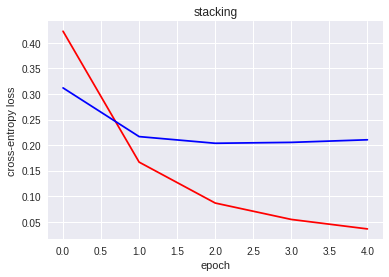

In [36]:
model = stack_nn(4, X_train.shape[1], lr=1e-4)
hist = model.fit([X_train.values, S_train], Y_train.values, batch_size=32, nb_epoch=50, verbose=1, 
                 validation_data=([X_val.values, S_val], Y_val.values), 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=1)], shuffle=True)
hist = {'loss':hist.history['loss'], 'val_loss':hist.history['val_loss']}

plt.plot(range(len(hist['loss'])), hist['loss'], c='r', label='train')
plt.plot(range(len(hist['val_loss'])), hist['val_loss'], c='b', label='valid')
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')
plt.title('stacking')
plt.savefig('fig/stack1.png')

hist_path, mdl_path = 'ckpt/stack2.pkl', 'ckpt/stack2.h5'
cPickle.dump(hist, open(hist_path, 'wb'))
model.save(mdl_path)

In [37]:
model = load_model('ckpt/stack2.h5')
pred5 = model.predict([X_val.values, S_val]).reshape((-1))
print('NN-stacking: {}'.format(roc_auc_score(Y_val, pred5)))

NN-stacking: 0.957795053501782


In [38]:
def compute_sweight(cur,n=15):
    S, CMB = [], []
    for b in range(15):
        for c in range(15):
            for d in range(15):
                y_pred = pred5*cur + pred2*b + pred3*c + pred4*d
                S.append(roc_auc_score(Y_val, y_pred))
                CMB.append((cur,b,c,d))
    return [S, CMB]

pn=15
pool=multiprocessing.Pool(processes=pn)
results=pool.map(compute_sweight, range(pn))
pool.close()
pool.join()

S, CMB = [], []
for i in range(pn):
    S.extend(results[i][0])
    CMB.extend(results[i][1])

top = np.argsort(S)[-1]
bab, bscore = CMB[top], S[top]
print('{}: {}'.format(bab, bscore))

(1, 2, 0, 11): 0.9604290510999173


## Generate Prediction

In [39]:
X = pd.concat([X_train, X_val])
Y = pd.concat([Y_train, Y_val])
# train on all training data
clf1.fit(X, Y)
clf2.fit(X, Y)
clf3.fit(X, Y)
bst = xgb.train(params, xgb.DMatrix(X, label=Y), 2001, watchlist, early_stopping_rounds=50, verbose_eval=1000)
pred1 = clf1.predict_proba(test_X)[:,1]
pred2 = clf2.predict_proba(test_X)[:,1]
pred3 = clf3.predict_proba(test_X)[:,1]
d_test = xgb.DMatrix(test_X)
pred4 = bst.predict(d_test)

[0]	train-logloss:0.679262	valid-logloss:0.679308
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[1000]	train-logloss:0.18712	valid-logloss:0.187961
[2000]	train-logloss:0.179277	valid-logloss:0.180125


In [49]:
# stack
S_test = np.hstack([pred1.reshape((-1,1)), pred2.reshape((-1,1)), pred3.reshape((-1,1)), pred4.reshape((-1,1))])
pred5 = model.predict([test_X.values, S_test]).reshape((-1))

a, b, c, d = bab
y_pred = (pred5*a + pred2*b + pred3*c + pred4*d)/(a+b+c+d)
pred = pd.DataFrame({'test_id':test_id,'is_duplicate':y_pred})
pred.to_csv('sub/sub-mine-min-stack.csv', index=False)

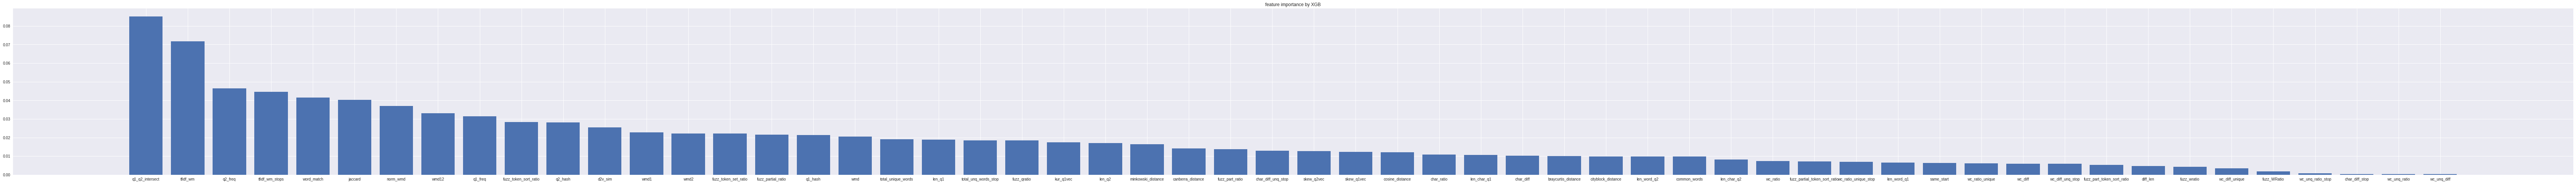

In [50]:
def get_xgb_imp(bst, F, out=''):
    imp_vals = bst.get_fscore()
    total = np.array(list(imp_vals.values())).sum()
    dic = {k:v/total for k,v in imp_vals.items()}
    sdic = list(reversed(sorted([(v,k) for (k,v) in dic.items()])))
    fig = plt.figure(figsize=(120,8))
    plt.title('feature importance by XGB')
    plt.bar(range(len(sdic)), [x[0] for x in sdic])
    plt.xticks(range(len(sdic)), [x[1] for x in sdic])
    if len(out)>0:
        plt.savefig(out)
    else:
        plt.show()
    
get_xgb_imp(bst, F, out='fig/imp-mine-min-stack.png')